# Final Practice - Brain Tumor Detection Using Semantic Segmentation
### Visión Artificial. GITT-GIEC-GII
#### Luis M. Bergasa, Miguel A. García. Department of Electronics. University of Alcalá. Spain

## Goal

The aim of this practice is to apply deep learning techniques for the semantic segmentation of brain tumors in medical imaging using  Magnetic Resonance Imaging (MRI) data from a public dataset such as BRATS, available on platforms like Kaggle. The student will implement and train a convolutional neural network for segmentation, apply appropriate pre- and post-processing steps, and evaluate the model using metrics specific to segmentation performance. The student must use PyTorch as the deep learning framework, OpenCV for image processing, and matplotlib or similar libraries for the visual analysis of results.


## General description

The pipeline to be developed should follow these stages:

1. **Load and preprocess** the MRI dataset from Kaggle. Split the data into training, validation, and test sets. Resize and normalize the images, and prepare corresponding binary segmentation masks.
2. **Design and implement** a semantic segmentation network (preferably U-Net or a similar encoder-decoder architecture).
3. **Train the model** using appropriate loss functions for segmentation (e.g., Dice Loss, Binary Cross-Entropy), including early stopping or learning rate scheduling.
4. **Validate the model** on unseen data and visualize predictions.
5. **Evaluate performance** using segmentation metrics (e.g. IoU).
6. **Provide qualitative results** showing predicted masks overlayed on original images, with proper color coding.

Concepts related to this practice have been studied mainly in Topic 5 of the course. It is recommended that its practical implementation is carried out using as a basis the codes of the practices, since they may serve as a guide at the time of implementing everything.

The data for the evaluation and training of the algorithm will be obtained from the [BraTS 2020 Training Data](https://www.kaggle.com/datasets/awsaf49/brats2020-training-data) available on Kaggle. This dataset contains pre-operative MRI scans of brain tumor patients, collected from multiple institutions and annotated by expert neuroradiologists. Each subject includes four MRI modalities: T1-weighted, T1 with contrast enhancement (T1Gd), T2-weighted, and FLAIR, along with ground truth segmentation masks identifying three tumor sub-regions—enhancing tumor, peritumoral edema, and necrotic core. Semantic segmentation is critical in this context to accurately localize and classify tumor areas that may be difficult to distinguish visually due to intensity inhomogeneity and irregular boundaries. An example from the BraTS dataset is shown in Figure 1, illustrating the multimodal MRI input and corresponding multi-class segmentation masks. The dataset consists of 369 subjects, and it is recommended to follow a 70% training, 15% validation, and 15% testing split to ensure consistent model evaluation.
 

|Figure 1. Brain Tumor Detection Image examples |
|:-:|
|<img src="jupyter_imgs/brats.jpg" style="width:800px;height:300px;">|

To perform semantic segmentation on the ultrasound images, a convolutional neural network architecture based on U-Net will be used. U-Net is a widely adopted encoder-decoder architecture designed specifically for biomedical image segmentation tasks. Its structure allows for precise localization through skip connections that combine high-resolution features from the contracting path with the upsampled output. This facilitates the accurate segmentation of small or irregular tumor regions in breast ultrasound images. Figure 2 shows a schematic representation of the U-Net architecture that the student should implement or adapt, serving as a reference for the model to be trained in this project.

|Figure 2. Schematic example of U-Net architecture|
|:-:|
|<img src="jupyter_imgs/Unet.png" style="width:650px;height:360px;">|

To evaluate the performance of the segmentation model, some standard metrics are used. Specifically, the Dice coefficient and the Intersection over Union (IoU) are used to measure the overlap between the predicted mask and the ground truth. The Dice coefficient evaluates the similarity between two sets by comparing their intersection over the average size, while IoU quantifies the ratio between the intersection and the union of the predicted and true regions. These metrics are particularly suitable for medical image segmentation, where pixel-level accuracy is crucial. 


## Assessment

### 1. To obtain a maximum grade of *6* is required:
- Successfully load and preprocess the brain MRI dataset (using the FLAIR modality and the corresponding tumor masks by combining the three segmentation classes—edema (label 2), enhancing tumor (label 4), and necrotic core (label 1)—into a single binary mask), implement a working U-Net architecture (or similar) and train the model on the training set and obtain prediction masks on the validation or test set. 

### 2. To obtain a maximum grade of *8* is required additionally:
- Generate qualitative visual results by overlaying the predicted segmentation masks onto the original MRI slices. Use different colors or transparencies to distinguish between predicted tumor regions and ground truth masks. Apply data augmentation techniques (e.g., random horizontal/vertical flips, rotations, elastic deformations) during training to improve generalization performance.

### 3. To obtain a maximum grade of *10* is required additionally:
- Evaluate the model using the Dice coefficient and Intersection over Union (IoU) metrics:
<table style="width:40%;">
  <tr>
    <td align="left" style="width:100%;">
      $$
      \text{Dice} = \frac{2 \cdot |A \cap B|}{|A| + |B|}
      $$
    </td>
    <td align="right" style="width:100%;">
      $$
      \text{IoU} = \frac{|A \cap B|}{|A \cup B|}
      $$
    </td>
  </tr>
</table>


- where **A** is the predicted segmentation and **B** is the ground truth mask.

- Plot the Dice and IoU scores for the test dataset. Analyze at least 3 failure cases and discuss the potential sources of error or misclassification.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.transform import resize
import cv2
import kagglehub
import pandas as pd
import h5py
import random

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A


C:\Users\rasec\anaconda3\envs\VA_pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Obtencion de archivos

In [2]:

# Set the path to the file you'd like to load
file_path = ""

# Load the dataset using the updated API
df = kagglehub.dataset_download(
    "awsaf49/brats2020-training-data",
    path=file_path,  # Optional: forces fresh download
)

print("Path to dataset files:", df)


Path to dataset files: C:\Users\rasec\.cache\kagglehub\datasets\awsaf49\brats2020-training-data\versions\3


In [3]:
print(torch.__version__)  # Verifica la versión de PyTorch
print(torch.cuda.is_available())  # Debe devolver True si detecta la GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Número de GPUs disponibles: {torch.cuda.device_count()}")
    print(f"Nombre de la GPU: {torch.cuda.get_device_name(0)}")
    print(f"Capacidad de computación: {torch.cuda.get_device_capability(0)}")
    print(f"Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

else:
    device = torch.device('cpu')
    print("PyTorch no detecta una GPU compatible con CUDA.")

print(device)
print(torch.cuda.current_device())

2.5.1
True
Número de GPUs disponibles: 1
Nombre de la GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Capacidad de computación: (8, 9)
Memoria total: 6.00 GB
cuda
0


In [4]:
data_dir = df+'\\BraTS2020_training_data\\content\\data'
# --------------------------- Obtener todos los archivos del dataset ---------------------------
h5_files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]


if not h5_files:
    print(f"No se encontro los archivos .h5: {data_dir}")
else:
    print("Se obtubireron los archivos")


Se obtubireron los archivos


In [5]:
# Open the first .h5 file in the list to inspect its contents
if h5_files:
    for i in range(0, 16):
        print(f'Archivo {i}')
        selected_file = random.choice(h5_files)
        file_path = os.path.join(data_dir, selected_file)
        with h5py.File(file_path, 'r') as file:
            print("\nKeys for each file:", list(file.keys()))
            for key in file.keys():
                print(f"\nData type of {key}:", type(file[key][()]))
                print(f"Shape of {key}:", file[key].shape)
                print(f"Array dtype: {file[key].dtype}")
                print(f"Array max val: {np.max(file[key])}")
                print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Archivo 0

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.710200235387402
Array min val: -0.574100069343071

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 0
Array min val: 0
Archivo 1

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 0.0
Array min val: 0.0

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 0
Array min val: 0
Archivo 2

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 6.46986318721529
Array min val: -0.5758997788617505

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0
Archivo 3

Keys

volume_64_slice_43.h5
240
240
240


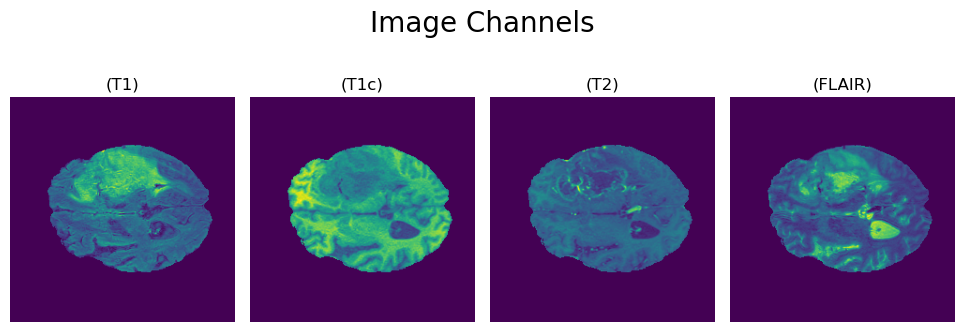

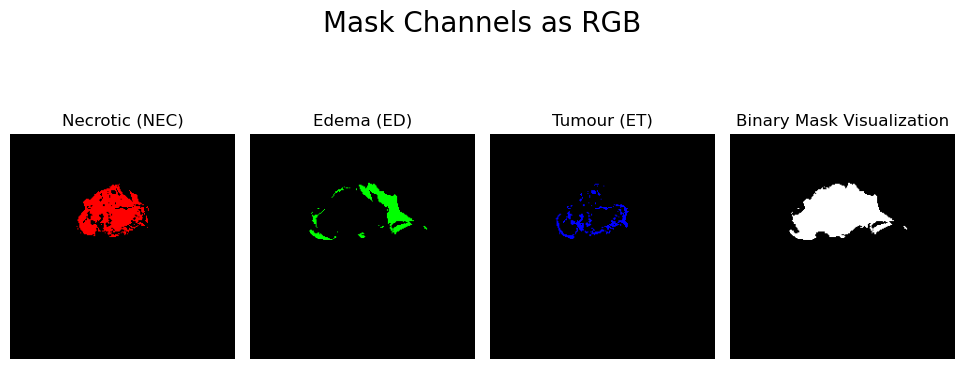

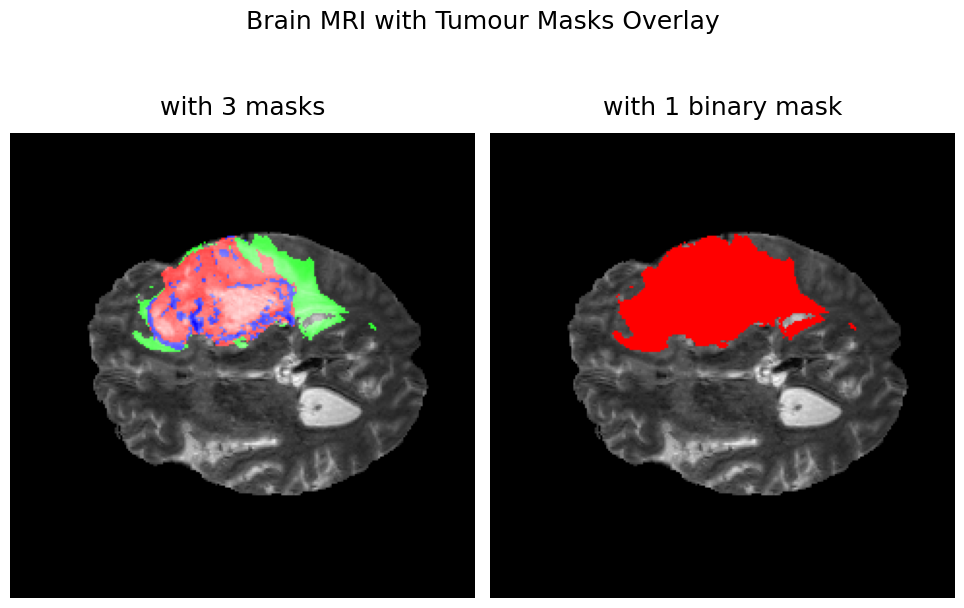

In [6]:

def display_image_channels(image, title='Image Channels'):
    channel_names = ['(T1)', '(T1c)', '(T2)', '(FLAIR)']
    fig, axes = plt.subplots(1, 4, figsize=(9.75, 5))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image)    
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=0.9)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 4, figsize=(9.75, 5))
    combined_mask = np.any(mask, axis=0).astype(np.uint8)
    for idx, ax in enumerate(axes):
        if idx < 3:
            rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
            rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        
            ax.imshow(rgb_mask)
            ax.axis('off')
            ax.set_title(channel_names[idx])
        else:
            ax.imshow(combined_mask, cmap='gray')
            ax.axis('off')
            ax.set_title('Binary Mask Visualization')
        
    
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()
    
def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[3, :, :] 
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)

    fig, axes = plt.subplots(1, 2, figsize=(9.75, 7))

    axes[0].imshow(rgb_image)
    axes[0].set_title('with 3 masks', fontsize=18, y=1.02)
    axes[0].axis('off')
    # Combinar todas las máscaras en una sola
    combined_mask = np.any(mask, axis=0).astype(bool)

    # Aplicar máscara en rojo (R=1, G=0, B=0) con 50% de transparencia
    rgb_image[combined_mask] = [1.0, 0.0, 0.0]

    axes[1].imshow(rgb_image)
    axes[1].set_title('with 1 binary mask', fontsize=18, y=1.02)
    axes[1].axis('off')
    
    fig.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

#if you want a random example
sample_selected = random.choice(h5_files)
print(sample_selected)

#if you want a spesific example
sample_file_path = os.path.join(data_dir, 'volume_20_slice_61.h5')
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)
image_prueba = image.transpose((2, 0, 1))
print(image.shape[1])
print(image.shape[2])
print(image_prueba.shape[0])

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)


# Preprocesamiento

In [10]:
class BrainScanDataset(Dataset):
    def __init__(self, file_paths, transform=None, deterministic=False):
        self.file_paths = file_paths
        self.transform = transform  # Transformación de albumentations (o None)
        if deterministic:
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
    
    def __len__(self):
        return len(self.file_paths)  # <- Esto es crítico para el DataLoader
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]  # Shape: (H, W, C)
            mask = file['mask'][()]    # Shape: (H, W, C)
            
            # Preprocesamiento
            
            mask = mask.transpose((2, 0, 1))
            image = image.transpose((2, 0, 1))  # (C, H, W)
            
            image = image[3:4, :, :]  # Tomar solo el canal deseado (1, H, W)
            binary_mask = np.any(mask, axis=0).astype(np.float32)  # (H, W)

            # Normalizar imagen
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)

            # Convertir a numpy (albumentations espera HWC)
            image_np = image.squeeze(0)  # (H, W)
            mask_np = binary_mask  # (H, W)

            # Aplicar transformaciones si existen
            if self.transform is not None:
                transformed = self.transform(image=image_np, mask=mask_np)
                image_np = transformed["image"]
                mask_np = transformed["mask"]

            # Convertir a tensores PyTorch (C, H, W)
            image_tensor = torch.from_numpy(image_np).unsqueeze(0).float()  # (1, H, W)
            mask_tensor = torch.from_numpy(mask_np).unsqueeze(0).float()   # (1, H, W)
            
        return image_tensor, mask_tensor
        


In [11]:
# --------------------------- Transformaciones ---------------------------------------------------------------------

aug_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ElasticTransform(alpha=5, sigma=3, p=0.5),
], additional_targets={'mask': 'image'})

In [12]:
# --------------------------- Obtener todos los archivos del dataset -----------------------------------------------

data_dir = df+'\\BraTS2020_training_data\\content\\data'
h5_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.h5')]  # Ruta completa

# --------------------------- Dividir datos de entrenamiento, validacion y test ------------------------------------

train_files, temp_files = train_test_split(h5_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)


print(f"Total samples: {len(h5_files)}")
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Test samples: {len(test_files)}")

# --------------------------- Creamos los dataset ------------------------------------------------------------------

train_dataset = BrainScanDataset(train_files, transform=aug_transform)
val_dataset = BrainScanDataset(val_files, deterministic=True)
test_dataset = BrainScanDataset(test_files, deterministic=True, transform=aug_transform)


# --------------------------- Creamos los dataloader ---------------------------------------------------------------

BATCH_S = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_S, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_S, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_S, shuffle=False)



images, masks = next(iter( train_dataloader))
print(f"Train batch - images: {images.shape}, masks: {masks.shape}")

images, masks = next(iter(val_dataloader))
print(f"Validation batch - images: {images.shape}, masks: {masks.shape}")

images, masks = next(iter(test_dataloader))
print(f"Test batch - images: {images.shape}, masks: {masks.shape}")


Total samples: 57195
Training samples: 40036
Validation samples: 8579
Test samples: 8580
Train batch - images: torch.Size([32, 1, 240, 240]), masks: torch.Size([32, 1, 240, 240])
Validation batch - images: torch.Size([32, 1, 240, 240]), masks: torch.Size([32, 1, 240, 240])
Test batch - images: torch.Size([32, 1, 240, 240]), masks: torch.Size([32, 1, 240, 240])



--- Image Info ---
Type: <class 'numpy.ndarray'>
Shape: (240, 240)
Dtype: float32
Max val: 0.981182
Min val: 0.0

--- Mask Info ---
Type: <class 'numpy.ndarray'>
Shape: (240, 240)
Dtype: float32
Max val: 1.0
Min val: 0.0


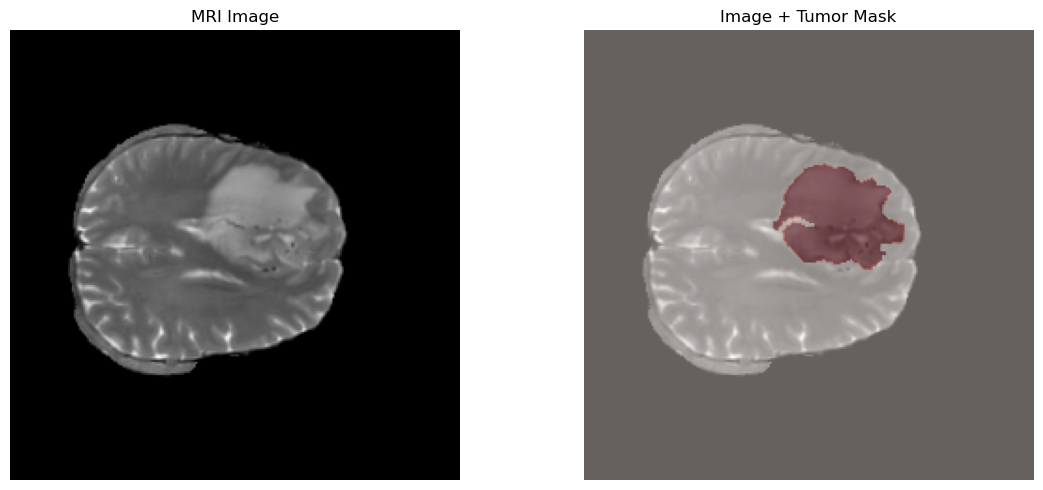

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5825148..4.685248].


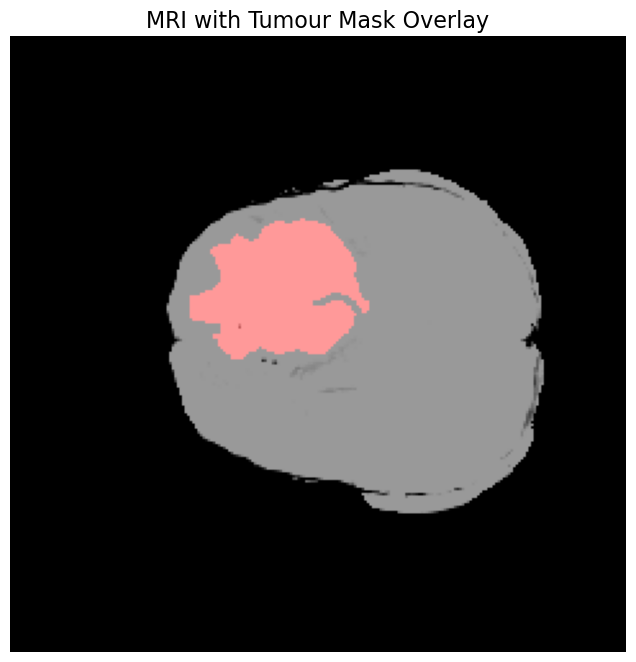


--- Image Info ---
Type: <class 'numpy.ndarray'>
Shape: (240, 240, 3)
Dtype: float32
Max val: 4.685248
Min val: -0.5825148

--- Mask Info ---
Type: <class 'numpy.ndarray'>
Shape: (240, 240, 3)
Dtype: float32
Max val: 1.0
Min val: 0.0
images: (240, 240, 3), masks: (240, 240, 3)


In [13]:
def observar(idx):

    image_tensor, mask_tensor = train_dataset[idx]
  # o cualquier otro índice

    # Convertir a NumPy
    image_np = image_tensor.squeeze(0).numpy()  # de (1, H, W) a (H, W)
    mask_np = mask_tensor.squeeze(0).numpy()
    
    # Imprimir información de la imagen
    print("\n--- Image Info ---")
    print("Type:", type(image_np))
    print("Shape:", image_np.shape)
    print("Dtype:", image_np.dtype)
    print("Max val:", np.max(image_np))
    print("Min val:", np.min(image_np))
    
    # Imprimir información de la máscara
    print("\n--- Mask Info ---")
    print("Type:", type(mask_np))
    print("Shape:", mask_np.shape)
    print("Dtype:", mask_np.dtype)
    print("Max val:", np.max(mask_np))
    print("Min val:", np.min(mask_np))
    
    
    # Plotear imagen y máscara
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title('MRI Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image_np, cmap='gray')
    plt.imshow(mask_np, cmap='Reds', alpha=0.4) 
    plt.title('Image + Tumor Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#train_files
def obtener (idx,file_paths):
    mask_color=(1, 0, 0)
    alpha=0.4
    title='MRI with Tumour Mask Overlay'
    file_path = file_paths[idx]
    with h5py.File(file_path, 'r') as file:
        image = file['image'][()]  # Shape: (H, W, C)
        mask = file['mask'][()]
        
    mask = mask.transpose((2, 0, 1))
    image = image.transpose((2, 0, 1))
    
    image = image[3, :, :]  # (H, W)

    # Asegurar tipo float para visualización
    image = image.astype(np.float32)

    # Si la máscara tiene 3 canales (C, H, W), combinarla
    if mask.ndim == 3:
        mask = np.any(mask, axis=0)

    # Crear una imagen RGB
    rgb_image = np.stack([image] * 3, axis=-1)

    # Mostrar imagen base
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image, cmap='gray')  # Imagen base en escala de grises

    # Crear una imagen en color del mismo tamaño con el color deseado solo donde hay máscara
    color_overlay = np.zeros_like(rgb_image)
    for i in range(3):
        color_overlay[:, :, i] = mask * mask_color[i]

    # Superponer la máscara en color con alpha (transparencia)
    plt.imshow(color_overlay, alpha=alpha)

    # Ajustes del gráfico
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

    # Imprimir información de la imagen
    print("\n--- Image Info ---")
    print("Type:", type(rgb_image))
    print("Shape:", rgb_image.shape)
    print("Dtype:", rgb_image.dtype)
    print("Max val:", np.max(rgb_image))
    print("Min val:", np.min(rgb_image))
    
    # Imprimir información de la máscara
    print("\n--- Mask Info ---")
    print("Type:", type(color_overlay))
    print("Shape:", color_overlay.shape)
    print("Dtype:", color_overlay.dtype)
    print("Max val:", np.max(color_overlay))
    print("Min val:", np.min(color_overlay))

    print(f'images: {rgb_image.shape}, masks: {color_overlay.shape}')
observar(2)
obtener(2,train_files)

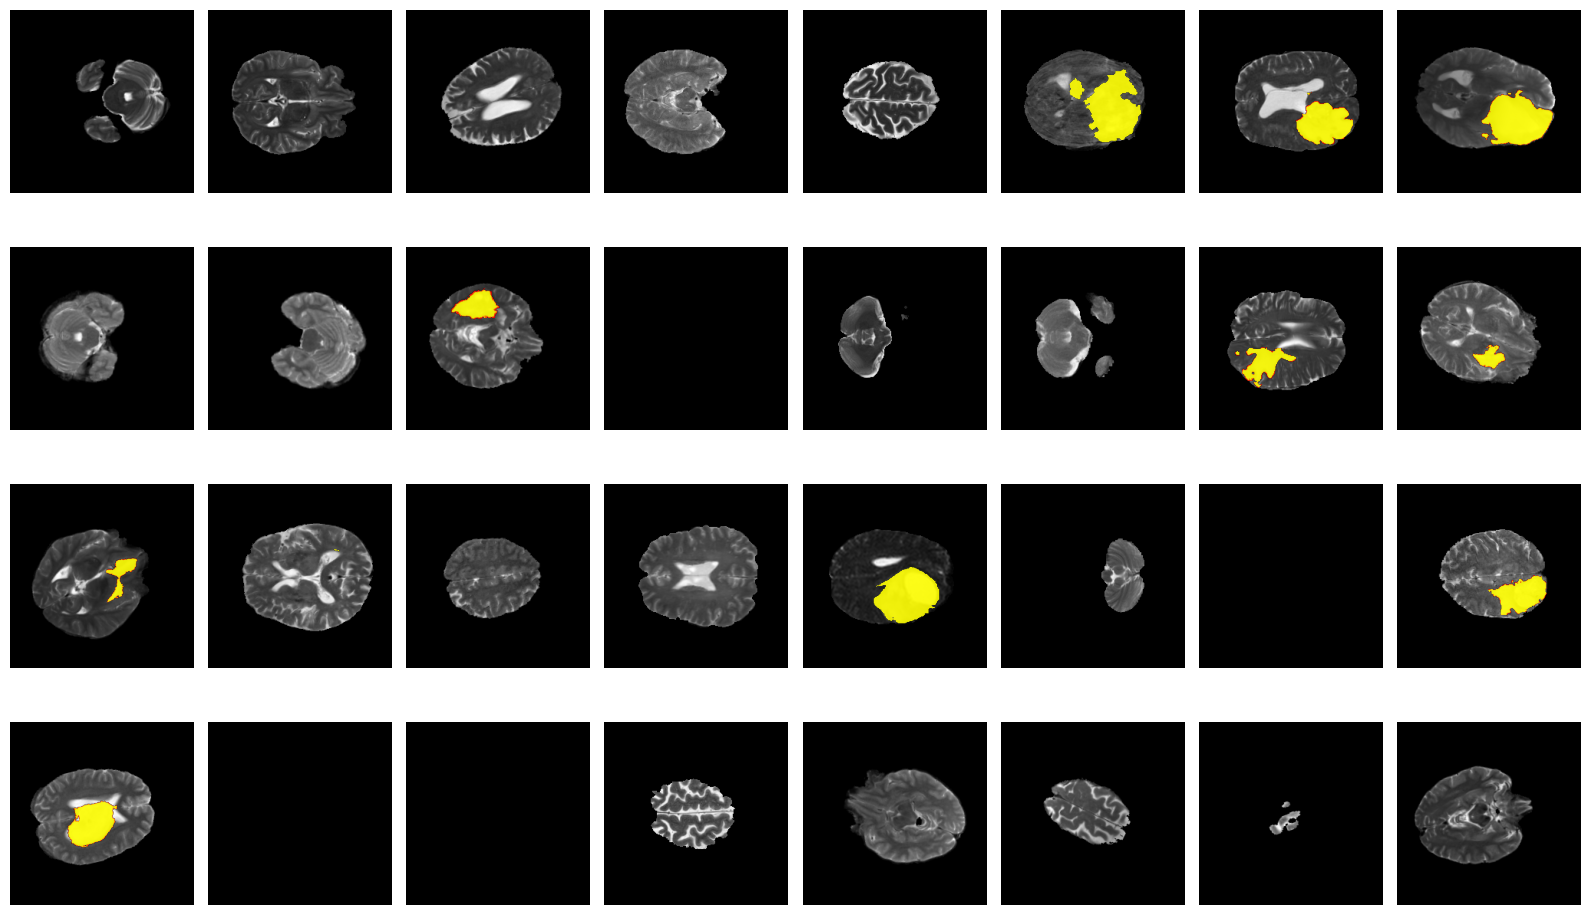

In [14]:
# --------------------------- Mostrar las mascaras resultandes del dataloader --------------------------------------
images, masks = next(iter( train_dataloader))
#images, masks = train_dataset[3]
def plot_mini_batch (imgs,masks, test_mask=None):
    plt.figure(figsize=(16,10))
    images = imgs.cpu().numpy()
    masks_n = masks.cpu().numpy()

    columns = (int)(BATCH_S/4)
    rows = (int)(BATCH_S/8)

    for i in range(BATCH_S):
        img = images[i].squeeze()
        mask = masks_n[i].squeeze()

        # Solo mostrar donde hay valor 1
        mask_m = np.ma.masked_where(mask == 0, mask)
        plt.subplot(rows,columns,i+1)
        plt.imshow(img, cmap='gray')
        plt.imshow(mask_m, cmap='autumn', alpha=0.9, vmin=0, vmax=1, interpolation=None)
        #plt.imshow(np.where(mask == 1, 1, np.nan), cmap='cool', alpha=1, vmin=0, vmax=1)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_mini_batch(images, masks)

# UNet

In [15]:
# --------------------------- Capa convolucional -------------------------------------------------------------------
class conv_3k(nn.Module):
    def __init__ (self,channels_in,channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in,channels_out,kernel_size=3,stride=1,padding=1)
    def forward(self, x):
        return self.conv1(x)
# --------------------------- Encoder Capa convolucional -----------------------------------------------------------
class conv_doble(nn.Module):
    def __init__ (self,channels_in,channels_out):
        super().__init__()
        self.conv_doble = nn.Sequential(
            conv_3k(channels_in,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),

            conv_3k(channels_out,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv_doble(x)
# --------------------------- Encoder Capa max pool ----------------------------------------------------------------
class maxPoll_convD(nn.Module):
    def __init__ (self,channels_in,channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2,2),
            conv_doble(channels_in,channels_out),
        )
    def forward(self, x):
        return self.encoder(x)
# --------------------------- Encoder_Capa Up convolucional --------------------------------------------------------
class up_conv(nn.Module):
    def __init__ (self,channels_in,channels_out):
        super().__init__()
        self.up_modificado = nn.Sequential(
            nn.Upsample(scale_factor=2,mode='bicubic'),
            nn.Conv2d(channels_in,channels_in//2,kernel_size=1,stride=1),
        )
        self.decoder = conv_doble(channels_in,channels_out)
    def forward(self, x1,x2):
        x1 = self.up_modificado(x1)
        x = torch.cat([x2,x1],dim=1)
        
        return self.decoder(x)
# --------------------------- Arquitectura UNet --------------------------------------------------------------------

class UNET(nn.Module):
    def __init__ (self,channels_in,channels,num_clases):
        super().__init__()
        self.down_part_one = conv_doble(channels_in,channels)
        self.down_part_two = maxPoll_convD(channels,2*channels)
        self.down_part_three = maxPoll_convD(2*channels,4*channels)
        self.down_part_four = maxPoll_convD(4*channels,8*channels)
        
        self.middle_part = maxPoll_convD(8*channels,16*channels)
        
        self.up_part_one = up_conv(16*channels,8*channels)
        self.up_part_two = up_conv(8*channels,4*channels)
        self.up_part_three = up_conv(4*channels,2*channels)
        self.up_part_four = up_conv(2*channels,channels)

        self.last_part = nn.Conv2d(1*channels, 1, kernel_size=1,stride=1)
        
    def forward(self, x):
        d1 = self.down_part_one(x)
        d2 = self.down_part_two(d1)
        d3 = self.down_part_three(d2)
        d4 = self.down_part_four(d3)

        m = self.middle_part(d4)
        
        u1 = self.up_part_one(m,d4)
        u2 = self.up_part_two(u1,d3)
        u3 = self.up_part_three(u2,d2)
        u4 = self.up_part_four(u3,d1)
        
        return self.last_part(u4)

In [16]:
# --------------------------- Coeficiente Dice ---------------------------------------------------------------------

def dice_coeff(pred, target):
    smooth = 1.0  # Para evitar división por cero
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2.0 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

# --------------------------- Intersection over Union --------------------------------------------------------------
def iou_coeff(pred, target):
    smooth = 1.0 
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    return (intersection + smooth) / (union + smooth)

In [17]:
# --------------------------- Función de pérdida personalizada -----------------------------------------------------

class DiceBCELoss(nn.Module):
    def __init__(self, weight=0.5):
        super().__init__()
        self.weight = weight
        
    def forward(self, preds, targets):
        bce = F.binary_cross_entropy_with_logits(preds, targets)
        preds = torch.sigmoid(preds)
        dice = 1 - dice_coeff(preds, targets)
        return self.weight*bce + (1-self.weight)*dice

# Entrenamiento

In [18]:
def train_model(model, train_dataloader, val_dataloader, config, verbose=True):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    weight_decay = config.get('weight_decay', 1e-5)

    model.to(device)
    print(batches_per_epoch)
    
# --------------------------- Optimizador AdamW  -------------------------------------------------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
# --------------------------- Scheduler ReduceLROnPlateau  ---------------------------------------------------------
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',       # Monitoreamos el Dice score (mayor es mejor)
        factor=0.5,       # Reduce LR multiplicando por 0.5
        patience=5,       # Espera 5 épocas sin mejora
        min_lr=1e-6       # Learning rate mínimo
    )

    loss_fn = DiceBCELoss(weight=0.7) 

# --------------------------- Historial de métricas ----------------------------------------------------------------
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': [],
        'train_iou': [],
        'val_iou': [],
        'lr': []  # Para trackear el learning rate
    }
    
    best_dice = 0.0 
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
# --------------------------- Entrenamiento ------------------------------------------------------------------------
        model.train()
        train_loss = 0
        train_dice = 0
        train_iou = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_dataloader, 1):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
# --------------------------- Forward pass -------------------------------------------------------------------------
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
# ---------------------------  Backward pass -----------------------------------------------------------------------
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
# --------------------------- Cálculo de métricas de entrenamiento -------------------------------------------------
            preds = (outputs > 0.5).float()
            dice = dice_coeff(preds, targets)
            iou = iou_coeff(preds, targets)
            
            train_loss += loss.item()
            train_dice += dice.item()
            train_iou += iou.item()
            
            if verbose:
                print(f"\rTrain batch: {batch_idx}/{batches_per_epoch} | "
                      f"Loss: {train_loss/batch_idx:.4f} | "
                      f"Dice: {train_dice/batch_idx:.4f} | "
                      f"IoU: {train_iou/batch_idx:.4f}", end='')
            
            if batch_idx >= batches_per_epoch:
                break
        
# --------------------------- Guardar métricas de entrenamiento ----------------------------------------------------
        history['train_loss'].append(train_loss / batches_per_epoch)
        history['train_dice'].append(train_dice / batches_per_epoch)
        history['train_iou'].append(train_iou / batches_per_epoch)
        
        if verbose:
            print()

# --------------------------- Validación ---------------------------------------------------------------------------
        model.eval()
        val_loss = 0
        val_dice = 0
        val_iou = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_dataloader, 1):
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                
# --------------------------- Guardar métricas de validacion -------------------------------------------------------
                preds = (outputs > 0.5).float()
                dice = dice_coeff(preds, targets)
                iou = iou_coeff(preds, targets)
                
                val_loss += loss.item()
                val_dice += dice.item()
                val_iou += iou.item()
                
                if verbose:
                    print(f"\rVal batch: {batch_idx}/{batches_per_epoch} | "
                          f"Loss: {val_loss/batch_idx:.4f} | "
                          f"Dice: {val_dice/batch_idx:.4f} | "
                          f"IoU: {val_iou/batch_idx:.4f}", end='')
                
                if batch_idx >= batches_per_epoch:
                    break
        
# --------------------------- Guardar métricas de validación -------------------------------------------------------
        val_loss_avg = val_loss / batches_per_epoch
        val_dice_avg = val_dice / batches_per_epoch
        val_iou_avg = val_iou / batches_per_epoch
        
        history['val_loss'].append(val_loss_avg)
        history['val_dice'].append(val_dice_avg)
        history['val_iou'].append(val_iou_avg)

        old_lr = optimizer.param_groups[0]['lr']
# --------------------------- Actualizar scheduler basado en el Dice score de validación ---------------------------
        scheduler.step(val_dice_avg)
        
# --------------------------- Obtener nuevo LR ---------------------------------------------------------------------
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
# --------------------------- Mostrar cambio de LR si ocurrió ------------------------------------------------------
        if current_lr != old_lr and verbose:
            print(f"\nLearning rate reducido de {old_lr:.2e} a {current_lr:.2e}")
        
# --------------------------- MÉTRICAS -----------------------------------------------------------------------------
        if verbose:
            print(f"\nEpoch {epoch}/{n_epochs} | "
                  f"Train Loss: {history['train_loss'][-1]:.4f} | "
                  f"Val Loss: {history['val_loss'][-1]:.4f} | "
                  f"Train Dice: {history['train_dice'][-1]:.4f} | "
                  f"Val Dice: {history['val_dice'][-1]:.4f} | "
                  f"Train IoU: {history['train_iou'][-1]:.4f} | "
                  f"Val IoU: {history['val_iou'][-1]:.4f} | "
                  f"LR: {current_lr:.6f}")
            
            # Opcional: Mostrar LR usando get_last_lr() si está disponible
            if hasattr(scheduler, 'get_last_lr'):
                print(f"(LR via get_last_lr(): {scheduler.get_last_lr()[0]:.6f})")
    
    print("Training complete.")
    return history

In [19]:
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    
# --------------------------- Pérdida ------------------------------------------------------------------------------

    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
# --------------------------- Dice Score ---------------------------------------------------------------------------
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['val_dice'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.legend()
    
# --------------------------- IoU ----------------------------------------------------------------------------------
    plt.subplot(1, 3, 3)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('Intersection over Union')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


250
Training...
Train batch: 250/250 | Loss: 0.4705 | Dice: 0.6322 | IoU: 0.4764
Val batch: 250/250 | Loss: 0.3834 | Dice: 0.7221 | IoU: 0.5686
Epoch 1/40 | Train Loss: 0.4705 | Val Loss: 0.3834 | Train Dice: 0.6322 | Val Dice: 0.7221 | Train IoU: 0.4764 | Val IoU: 0.5686 | LR: 0.000300
(LR via get_last_lr(): 0.000300)
Train batch: 250/250 | Loss: 0.3235 | Dice: 0.7269 | IoU: 0.5764
Val batch: 250/250 | Loss: 0.2765 | Dice: 0.7511 | IoU: 0.6054
Epoch 2/40 | Train Loss: 0.3235 | Val Loss: 0.2765 | Train Dice: 0.7269 | Val Dice: 0.7511 | Train IoU: 0.5764 | Val IoU: 0.6054 | LR: 0.000300
(LR via get_last_lr(): 0.000300)
Train batch: 250/250 | Loss: 0.2292 | Dice: 0.7335 | IoU: 0.5870
Val batch: 250/250 | Loss: 0.1947 | Dice: 0.7364 | IoU: 0.5873
Epoch 3/40 | Train Loss: 0.2292 | Val Loss: 0.1947 | Train Dice: 0.7335 | Val Dice: 0.7364 | Train IoU: 0.5870 | Val IoU: 0.5873 | LR: 0.000300
(LR via get_last_lr(): 0.000300)
Train batch: 250/250 | Loss: 0.1506 | Dice: 0.7623 | IoU: 0.6216
Val 

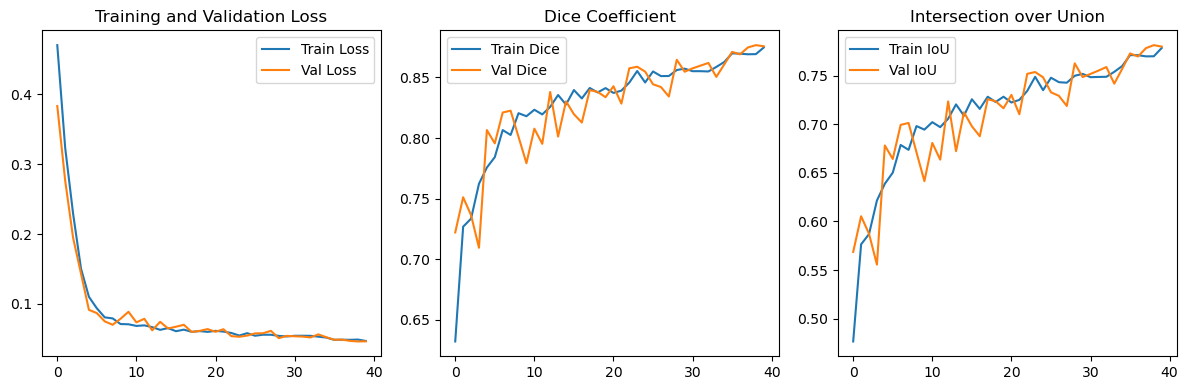

In [23]:
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          40,
    'batch_size':        32,
    'learning_rate':     3e-4,
    'weight_decay':      1e-5,
    'batches_per_epoch': 250
}
model = UNET(1, 32, 2)
history = train_model(model, train_dataloader, val_dataloader, train_config,verbose=True)
plot_metrics(history)

# Guardar y cargar entrenamiento

In [185]:
# --------------------------- Guardar red neuronal -----------------------------------------------------------------

model_path = './modelUNET_Prueba.pth'
torch.save(model.state_dict(), model_path)

model.state_dict()

OrderedDict([('down_part_one.conv_doble.0.conv1.weight',
              tensor([[[[ 0.1812, -0.1806, -0.2965],
                        [ 0.2379, -0.2589,  0.1043],
                        [ 0.2905, -0.1033,  0.0889]]],
              
              
                      [[[-0.0657,  0.0277, -0.0027],
                        [ 0.1542, -0.1007, -0.0552],
                        [-0.0162,  0.1034,  0.0324]]],
              
              
                      [[[-0.1991,  0.0991, -0.1595],
                        [-0.0655,  0.0567,  0.1077],
                        [-0.3027,  0.1118,  0.1035]]],
              
              
                      [[[-0.0994,  0.2954,  0.2376],
                        [ 0.3661,  0.2476, -0.3270],
                        [ 0.1580, -0.0243, -0.0014]]],
              
              
                      [[[-0.0343, -0.1413,  0.2967],
                        [ 0.0025,  0.1877,  0.1320],
                        [-0.0433, -0.1887, -0.1693]]],
              
   

In [105]:
#Cargar

model_path = './modelUNET_v6.pth'
model = UNET(1, 32, 2)
model.to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))  # o con weights_only=True si puedes
model.eval() # Cambia a modo evaluación si solo vas a inferir



UNET(
  (down_part_one): conv_doble(
    (conv_doble): Sequential(
      (0): conv_3k(
        (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): conv_3k(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_part_two): maxPoll_convD(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): conv_doble(
        (conv_doble): Sequential(
          (0): conv_3k(
            (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): conv_3k(
            (con

# Resultados


### Resultados con matplotlib

torch.Size([32, 1, 240, 240])
torch.Size([32, 1, 240, 240])


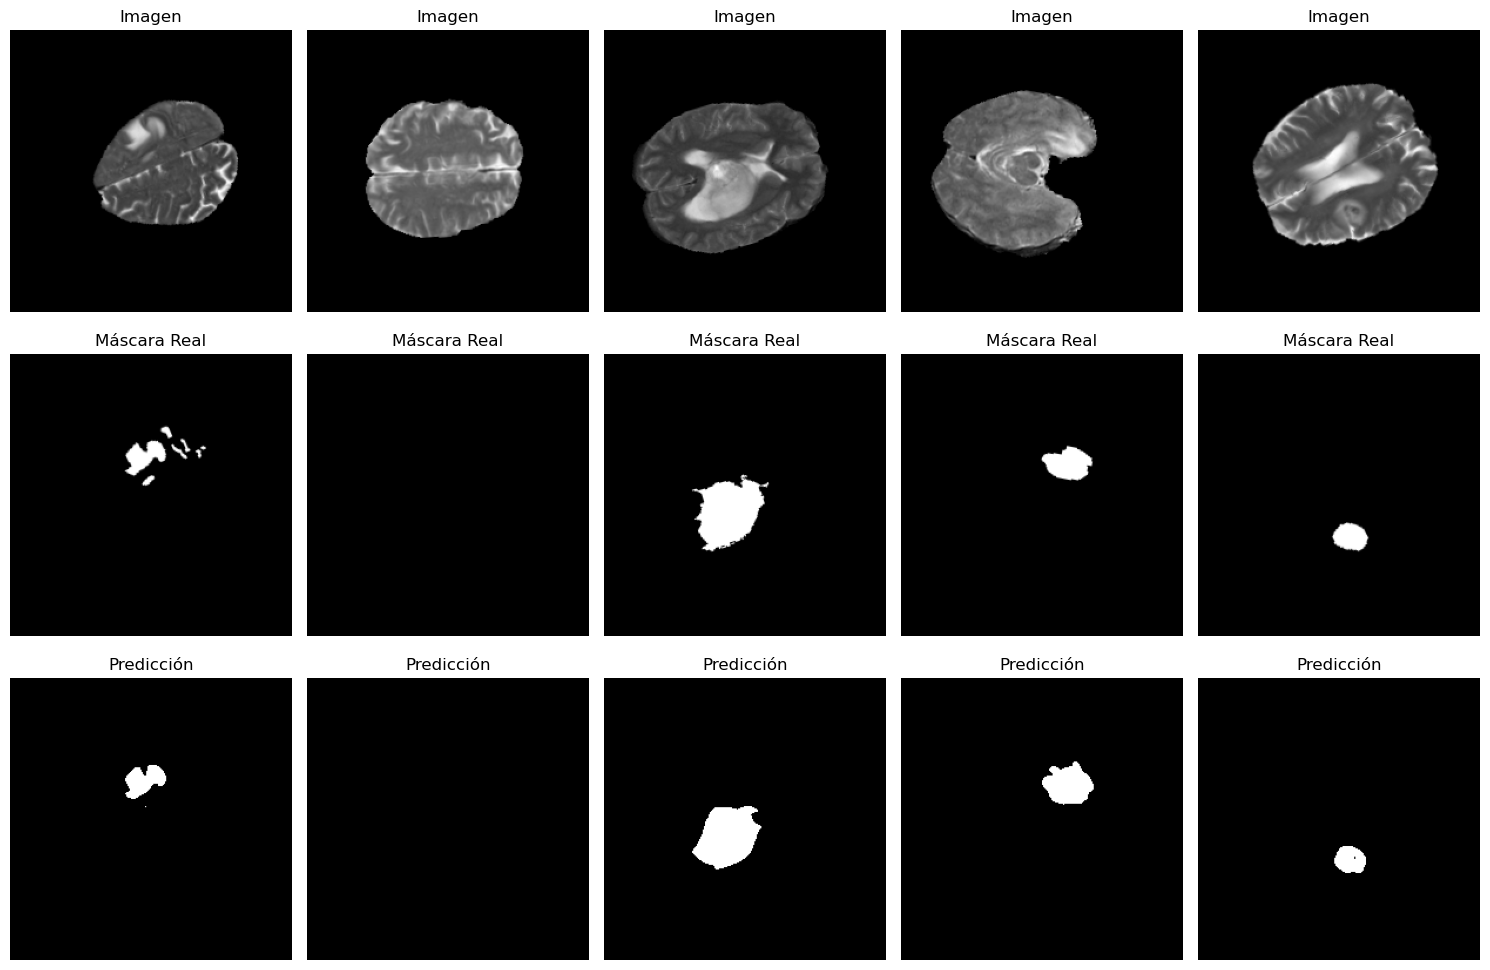

torch.Size([32, 1, 240, 240])
torch.Size([32, 1, 240, 240])
-- --


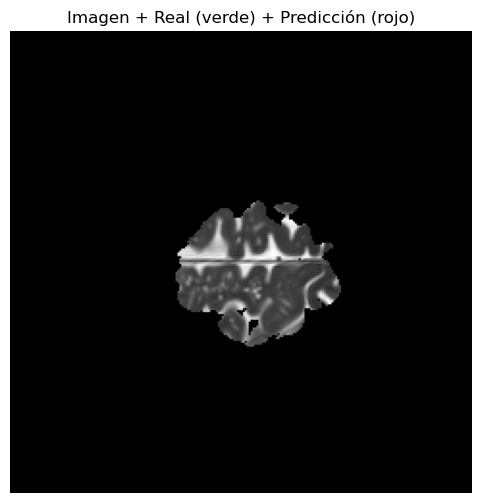

-- --


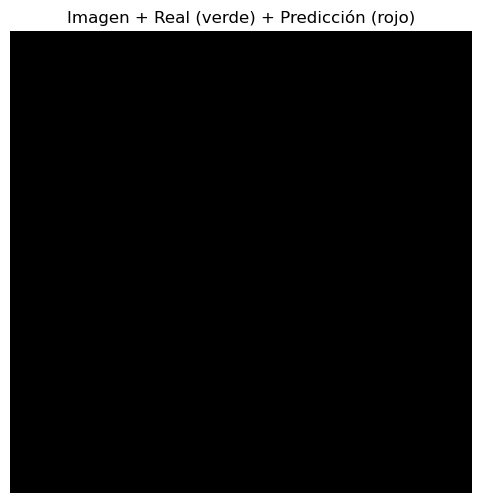

1200.0 607.9287


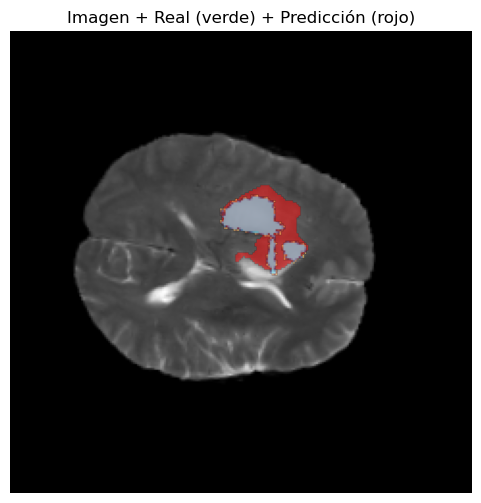

623.0 764.0


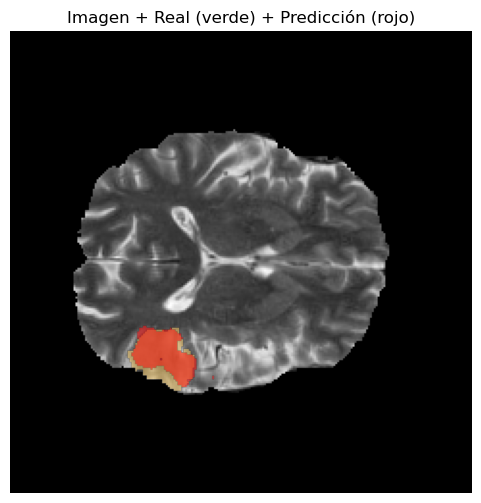

-- --


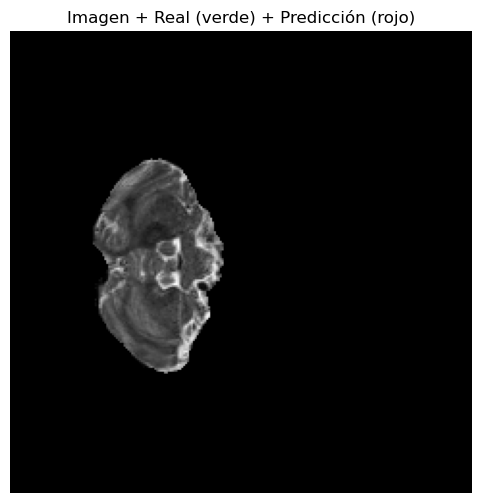

In [123]:

def visualize_predictions(model, dataloader,dataset, device,basico, num_samples=5):
    # Poner el modelo en modo evaluación
    model.eval()
    # Preparar la imagen
    
    # Obtener un batch de datos
    images, true_masks = next(iter(dataloader))
    
    images = images.to(device)
    true_masks = true_masks.to(device)
    print(images.shape)
    print(true_masks.shape)

    
    # Hacer predicciones (sin calcular gradientes)
    with torch.no_grad():
        preds = model(images)
        preds = (preds > 0.5).float()  # Umbralizar a máscara binaria

    
    
    # Convertir a numpy para visualización
    images_np = images.cpu().numpy()
    true_masks_np = true_masks.cpu().numpy()
    preds_np = preds.cpu().numpy()
    if basico == True:
        
        # Configurar la figura
        plt.figure(figsize=(15, 10))
        
        # Mostrar cada imagen
        for i in range(min(num_samples, len(images))):
            # Imagen original
            plt.subplot(3, num_samples, i+1)
            plt.imshow(images_np[i].squeeze(), cmap='gray')
            plt.title("Imagen")
            plt.axis('off')
            
            # Máscara verdadera
            plt.subplot(3, num_samples, i+1+num_samples)
            plt.imshow(true_masks_np[i].squeeze(), cmap='gray')
            plt.title("Máscara Real")
            plt.axis('off')
            
            # Predicción
            plt.subplot(3, num_samples, i+1+2*num_samples)
            plt.imshow(preds_np[i].squeeze(), cmap='gray')
            plt.title("Predicción")
            plt.axis('off')
    
        
        plt.tight_layout()
        plt.show()
    else:
        
        for i in range(min(num_samples, len(images))):
            img = images_np[i].squeeze()
            gt_mask = true_masks_np[i].squeeze()
            pred_mask = preds_np[i].squeeze()

            # Solo mostrar donde hay valor 1
            gt_mask_masked = np.ma.masked_where(gt_mask == 0, gt_mask)
            pred_mask_masked = np.ma.masked_where(pred_mask == 0, pred_mask)
            
            area_pred = np.sum(pred_mask_masked)
            area_true = np.sum(gt_mask_masked)
            print (area_pred, area_true)
            if area_pred>area_true :
                plt.figure(figsize=(6, 6))
                plt.imshow(img, cmap='gray')
                plt.imshow(pred_mask_masked, cmap='autumn', alpha=0.5)
                plt.imshow(gt_mask_masked, cmap='managua', alpha=0.6)
                plt.title("Imagen + Real (verde) + Predicción (rojo)")
                plt.axis('off')
                plt.show()
            else:
                plt.figure(figsize=(6, 6))
                plt.imshow(img, cmap='gray')
                plt.imshow(gt_mask_masked, cmap='managua', alpha=0.5)
                plt.imshow(pred_mask_masked, cmap='autumn', alpha=0.5)
                plt.title("Imagen + Real (verde) + Predicción (rojo)")
                plt.axis('off')
                plt.show()

# Uso:
config = {
    'device': 'cuda'
}
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_S, shuffle=True)
visualize_predictions(model, test_dataloader, test_dataset, device=config['device'], basico = True, num_samples=5)
visualize_predictions(model, test_dataloader, test_dataset, device=config['device'], basico = False, num_samples=5)


### Resultados con Open CV

In [125]:
def dice_coefficient(pred, target, epsilon=1e-6):
    # Flatten para evitar problemas de dimensiones
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

def iou_score(pred, target, epsilon=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + epsilon) / (union + epsilon)

In [32]:
def draw_bar_chart(data, title, size=(600, 400), color=(255, 0, 0)):
    """Dibuja un gráfico de barras con OpenCV."""
    height, width = size
    margin = 50
    chart_height = height - 2 * margin
    chart_width = width - 2 * margin
    
    # Crear una imagen en blanco
    img = np.ones((height, width, 3), dtype=np.uint8) * 255  # Fondo blanco
    
    # Normalizar datos para que quepan en el gráfico
    max_val = max(data) if max(data) != 0 else 1
    bar_width = chart_width // (len(data) + 1)
    
    # Dibujar ejes
    cv2.line(img, (margin, height - margin), (margin + chart_width, height - margin), (0, 0, 0), 2)  # Eje X
    cv2.line(img, (margin, height - margin), (margin, margin), (0, 0, 0), 2)  # Eje Y
    
    # Dibujar barras
    for i, value in enumerate(data):
        bar_height = int((value / max_val) * chart_height)
        x1 = margin + (i * bar_width) + 10
        y1 = height - margin - bar_height
        x2 = x1 + bar_width - 10
        y2 = height - margin
        
        cv2.rectangle(img, (x1, y1), (x2, y2), color, -1)  # -1 = relleno sólido
        cv2.putText(img, f"{value:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    # Añadir título
    cv2.putText(img, title, (margin, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    return img

In [177]:
import math
def visualize_predictions_CV2(model, dataloader, dataset, device, basico, num_samples=9):
    # Poner el modelo en modo evaluación
    model.eval()
    

    # Obtener un batch de datos
    images, true_masks = next(iter(dataloader))
    images = images.to(device)
    true_masks = true_masks.to(device)
    print(images.shape[0],images.shape[1],images.shape[2])
    print(true_masks.shape)

    valid_indices = []
    for i in range(len(true_masks)):
        if true_masks[i].sum() > 0:  # Si hay al menos un píxel con máscara
            valid_indices.append(i)
    actual_num_samples = min(num_samples, len(valid_indices))

    images = images[valid_indices[:actual_num_samples]]
    true_masks = true_masks[valid_indices[:actual_num_samples]]

    
    # Hacer predicciones (sin calcular gradientes)
    with torch.no_grad():
        preds = model(images)
        preds = (preds > 0.5).float()  # Umbralizar a máscara binaria

    # Calcular métricas para cada muestra
    dice_scores = []
    iou_scores = []
    
    for i in range(len(images)):
        dice = dice_coefficient(preds[i], true_masks[i])
        iou = iou_score(preds[i], true_masks[i])
        dice_scores.append(dice.item())
        iou_scores.append(iou.item())
    
    # Convertir a numpy para visualización
    images_np = images.cpu().numpy()
    true_masks_np = true_masks.cpu().numpy()
    preds_np = preds.cpu().numpy()
    
    # Normalizar imágenes a rango 0-255
    images_np = np.uint8(255 * (images_np - images_np.min()) / (images_np.max() - images_np.min()))
    img_height, img_width = images_np.shape[2], images_np.shape[3]
    if basico:
        # Configurar ventanas para visualización básica
        for i in range(min(num_samples, len(images))):
            img = images_np[i].squeeze()
            true_mask = true_masks_np[i].squeeze()
            pred_mask = preds_np[i].squeeze()
            
            # Convertir máscaras a 3 canales y color
            true_mask_colored = cv2.cvtColor(np.uint8(255 * true_mask), cv2.COLOR_GRAY2BGR)
            pred_mask_colored = cv2.cvtColor(np.uint8(255 * pred_mask), cv2.COLOR_GRAY2BGR)
            
            # Mostrar imágenes en ventanas separadas
            cv2.imshow(f'Imagen {i}', img)
            cv2.imshow(f'Máscara Real {i}', true_mask_colored)
            cv2.imshow(f'Predicción {i}', pred_mask_colored)
            
            # Esperar tecla para continuar
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    else:
        # Modo avanzado: organizar en grid cuadrado
        grid_size = math.ceil(math.sqrt(num_samples))
        combined_width = grid_size * img_width
        combined_height = grid_size * img_height
        combined = np.zeros((combined_height, combined_width, 3), dtype=np.uint8)
        
        for i in range(min(num_samples, len(images))):
            
            img = images_np[i].squeeze()
            true_mask = true_masks_np[i].squeeze()
            pred_mask = preds_np[i].squeeze()

            
            # Crear superposición
            img_colored = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            
            gt_mask_colored = np.zeros_like(img_colored)
            gt_mask_colored[true_mask > 0] = [0, 255, 0]  # Verde
            
            pred_mask_colored = np.zeros_like(img_colored)
            pred_mask_colored[pred_mask > 0] = [0, 0, 255]  # Rojo
            
            alpha = 0.5
            brighter_background = cv2.convertScaleAbs(img_colored, alpha=1.2, beta=50)  # alpha aumenta el contraste, beta el brillo

            overlay = brighter_background.copy()
            cv2.addWeighted(gt_mask_colored, alpha, overlay, 1 - alpha, 0, overlay)
            cv2.addWeighted(pred_mask_colored, alpha, overlay, 1 - alpha, 0, overlay)
            
            # Añadir texto
            area_true = np.sum(true_mask)
            area_pred = np.sum(pred_mask)
            cv2.putText(overlay, f"dice:{dice_scores[i]:.3f} iou:{iou_scores[i]:.3f}", 
                        (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            
            # Calcular posición en el grid
            row = i // grid_size
            col = i % grid_size
            x_start = col * img_width
            y_start = row * img_height
            combined[y_start:y_start+img_height, x_start:x_start+img_width] = overlay
    
        # --- Crear gráficos con OpenCV ---
    dice_chart = draw_bar_chart(dice_scores, "Dice Scores", color=(0, 0, 255))  # Rojo
    iou_chart = draw_bar_chart(iou_scores, "IoU Scores", color=(0, 255, 0))    # Verde
    
    # Mostrar gráficos
    cv2.imshow("Dice Coefficient", dice_chart)
    cv2.imwrite("Dice.jpg", dice_chart)
    cv2.imshow("IoU Score", iou_chart)
    cv2.imwrite("IoU.jpg", iou_chart)
    # Redimensionar si es muy grande
    max_display_size = 1200
    if max(combined.shape[0], combined.shape[1]) > max_display_size:
        scale = max_display_size / max(combined.shape[0], combined.shape[1])
        combined = cv2.resize(combined, (0, 0), fx=scale, fy=scale)
    
    # Mostrar resultados
    window_name = "Modo Básico" if basico else "Modo Avanzado - Grid Cuadrado"
    cv2.imshow(window_name, combined)
    cv2.imwrite("Resultados.jpg", combined)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



visualize_predictions_CV2(model, test_dataloader, test_dataset, device=config['device'], basico = False, num_samples=9)

32 1 240
torch.Size([32, 1, 240, 240])


(np.float64(-0.5), np.float64(399.5), np.float64(599.5), np.float64(-0.5))

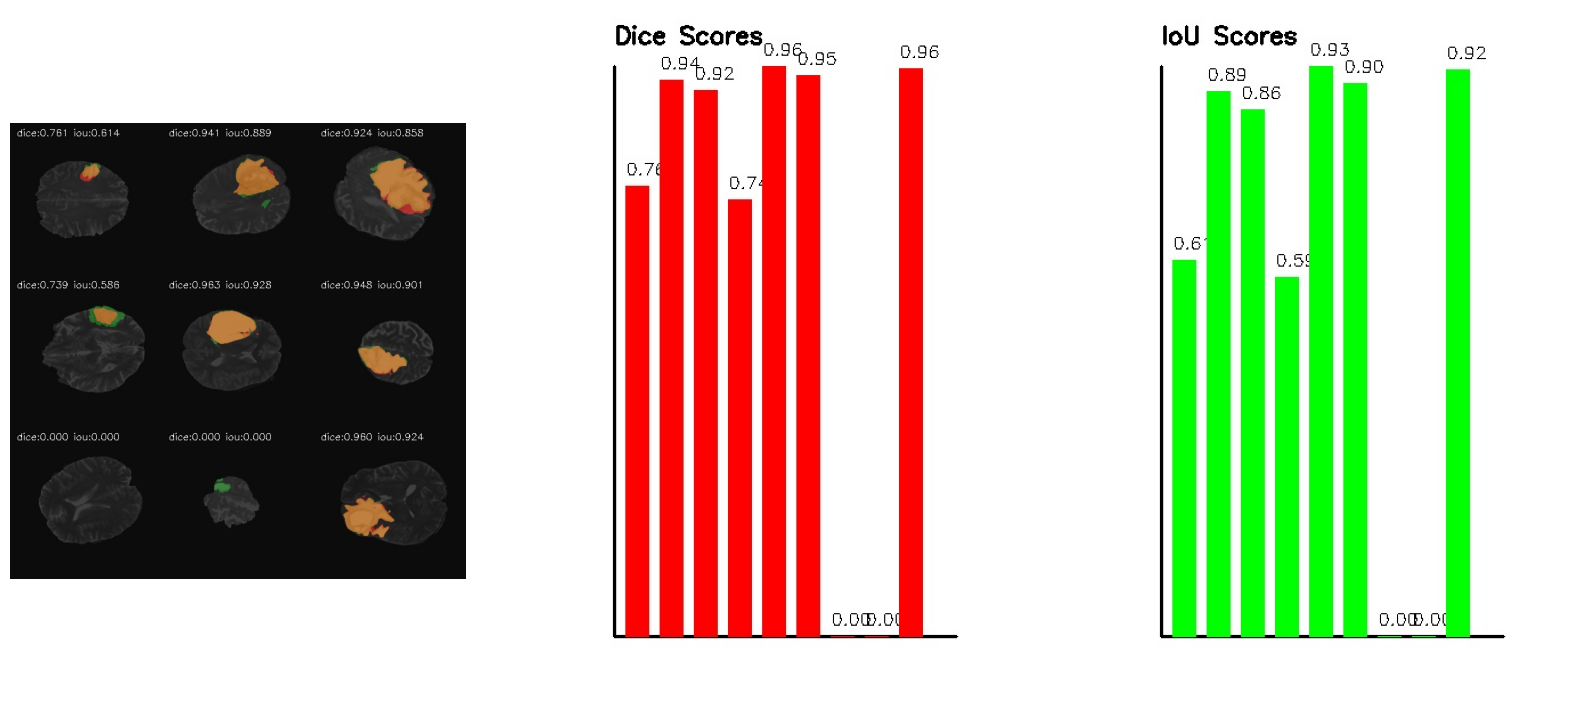

In [184]:
import matplotlib.image as mpimg
resultados = mpimg.imread('./Resultados.jpg')
Dice = mpimg.imread('./Dice.jpg')
IoU = mpimg.imread('./IoU.jpg')

plt.figure(figsize=(20, 20))

plt.subplot(1,3,1)
plt.imshow(resultados)
plt.axis('off')


plt.subplot(1,3,2)
plt.imshow(Dice)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(IoU)
plt.axis('off')


### Resultados marcados como erroneos

In [157]:
def visualize_predictions_erroneos(model, dataset, device, basico, specific_indices=None, num_samples=5):
    # Poner el modelo en modo evaluación
    model.eval()

    if specific_indices is not None:
        # Crear un batch personalizado con las imágenes específicas
        images = []
        true_masks = []
        for idx in specific_indices:
            img, mask = dataset[idx]  # Obtener la imagen y máscara del dataset directamente
            images.append(img)
            true_masks.append(mask)
        
        # Convertir a tensores y agregar dimensión de batch
        images = torch.stack(images).to(device)
        true_masks = torch.stack(true_masks).to(device)
    else:
        # Obtener un batch aleatorio como antes
        images, true_masks = next(iter(dataloader))
        images = images.to(device)
        true_masks = true_masks.to(device)
    
    # Hacer predicciones (sin calcular gradientes)
    with torch.no_grad():
        preds = model(images)
        preds = (preds > 0.5).float()  # Umbralizar a máscara binaria

    # Convertir a numpy para visualización
    images_np = images.cpu().numpy()
    true_masks_np = true_masks.cpu().numpy()
    preds_np = preds.cpu().numpy()

    plt.figure(figsize=(10, 16))
    for i in range(min(num_samples, len(images))):
        img = images_np[i].squeeze()
        gt_mask = true_masks_np[i].squeeze()
        pred_mask = preds_np[i].squeeze()
        
        # Solo mostrar donde hay valor 1
        gt_mask_masked = np.ma.masked_where(gt_mask == 0, gt_mask)
        pred_mask_masked = np.ma.masked_where(pred_mask == 0, pred_mask)
            
        area_pred = np.sum(pred_mask_masked)
        area_true = np.sum(gt_mask_masked)
        
            
        
        plt.subplot(1,3,i+1)

        plt.imshow(img, cmap='gray')
        if area_pred > area_true:
            
            plt.imshow(pred_mask_masked, cmap='autumn', alpha=0.5)
            plt.imshow(gt_mask_masked, cmap='viridis', alpha=0.5)
        else:
            plt.imshow(gt_mask_masked, cmap='viridis', alpha=0.5)
            plt.imshow(pred_mask_masked, cmap='autumn', alpha=0.5)
        
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("Erroneos2.jpg", bbox_inches='tight')
    
    plt.show()
    
        

# Uso:
config = {
    'device': 'cuda'
}


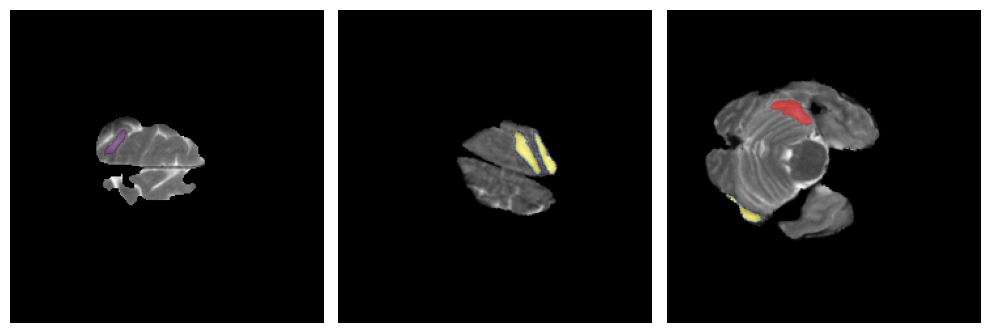

In [169]:

# Especificar los índices de las imágenes que quieres visualizar
specific_indices = [4, 37, 19] 


visualize_predictions_erroneos(
    model, 
    test_dataset, 
    device=config['device'], 
    basico=False, 
    specific_indices=specific_indices,
    num_samples=len(specific_indices)
)


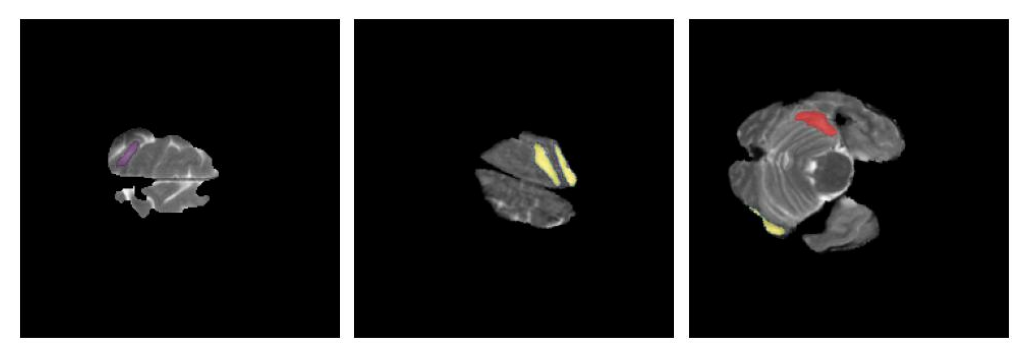

In [174]:
import matplotlib.image as mpimg
img = mpimg.imread('./Erroneos2.jpg')
plt.figure(figsize=(13, 16))
plt.axis('off')
imgplot = plt.imshow(img)

En este caso, estos 3 casos no se pudo clasificar correctamente, para ser especifico los 2 primeros no se genero alguna prediccion mientras que en el 3er caso la mascara que genero fue incorrecta.
Las razones por las que creo que no se predijo ninguna mascara para los 2 primeros casos tal vez sea por la peque;a cantidad de muestras de imagenes que tengan esas formas que son algo mas extrañas, incluso sin que esten rodadas, tal vez se solicionaria teniendo un mayor conjunto mayor de datos
Mientras que en el caso de la 3er imagen puede ser que al no tener toda la informacion de las otras 3 capas que nos permitiria tener algun panorama mas grande, pero al solo tener una sola imagen puede llegar a tomar pequeños cambios. En este caso parece que en esa seccion hay una pequeña variacion en tono de la imagen que hace creer que podria ser un tumor